# Demo 8 - Intro to PyTorch

Previously, we've been using `numpy` to do mathematical calculations and make our statistical machine learning models run quickly. But now, we'll be looking at neural networks, where we will want to mostly calculate lots and lots of neurons. Since our neurons are usually in the form $f(x) = h(wx + b)$ we tend to deal with __large matrix multiplications__ (as well as additions, etc...). Since our standard method of training is SGD, with mini-batches, we want to do these matrix multiplications across our whole batch, and the fastest way to do that is in __parallel__. The best hardware for that isn't the CPU we're used to working with but a __GPU!__ There are a number of libraries that are useful for creating neural networks and running them on GPU (Keras/Tensorflow, Chainer,...) but we will be using `PyTorch`

/

On a déjà utilisé numpy pour faire les calculs et accélérer notres modèles d'apprentissage machine. Mais maintenant, on va considerer les résaux de neurones, où la majorité de calculs est pour les neurones  𝑓(𝑥)=ℎ(𝑤𝑥+𝑏)  sous forme de grandes mutliplications de matrices. Parce qu'on utilise SGD avec mini-batches, on veut faire ces calculs en parallèle. Le CPU qu'on a utilisé n'est pas le meilleur matériel pour faire ces calculs, c'est mieux si on utilise le GPU. Il y a beaucoup de bibliothèques qu'on peut utiliser mais nous allons utiliser PyTorch

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

import torch

In [0]:
%pylab inline
import torch
print(torch.__version__)

Populating the interactive namespace from numpy and matplotlib
1.3.1


## PyTorch Tensors

Whereas `numpy` used `np.array` as the basic data structure, in `PyTorch` we will use the similar `torch.Tensor` which you can think of in the same way. The big difference is that `torch.Tensor` can also be moved to the GPU, where they use a library called `CUDA` under the hood to do calculations

/

La structure de base de `numpy` est `np.array`, de même,  en`PyTorch` on utilise `torch.Tensor`. La difference entre les deux c'est qu'on peut mettre `torch.Tensor` sur le  GPU, et utiliser un bibliothèque qui s'appele `CUDA` pour faire les calculs.

In [0]:
a = torch.Tensor([1,2,3])
W = torch.randn(3,3)
b = torch.Tensor([4,5,6]).view(3,1)
print(W.mm(b))

tensor([[ -8.3759],
        [-11.5405],
        [  1.4880]])


In [0]:
device = torch.device('cuda:0')    # we use 0 to specify the first GPU
a = a.to(device)
b = b.to(device)
c = torch.ones(3, device=device)
print(a + b + c)

tensor([[ 6.,  7.,  8.],
        [ 7.,  8.,  9.],
        [ 8.,  9., 10.]], device='cuda:0')


## Iris Classification in PyTorch

Let's load  `iris.txt` using the `sklearn` library, we can then preprocess the labels and convert them to one hot encoding

/

On commence par charger la base de données `iris` avec la bibliothèque `sklearn`, et on passe les labels en encodage one-hot

In [0]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

iris = datasets.load_iris()

# separate into train/test using sklearn
(x_train, x_test, y_train, y_test) = train_test_split(iris.data, iris.target)

num_train = x_train.shape[0]
num_test = x_test.shape[0]
num_features = x_train.shape[1]
num_classes = 3

# lets also convert our targets y to a one-hot encoding 
# e.g. 1 -> [0, 1, 0], 2 -> [0, 0 ,1]  
one_hot = OneHotEncoder(n_values=num_classes, sparse=False)
y_train = one_hot.fit_transform(y_train.reshape(-1,1))
y_test = one_hot.transform(y_test.reshape(-1,1))

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


Finally, we'll convert our data to `torch.Tensor` representations, and because we can only have operations between arguments of the same type so lets make everything a `float` as well

/

Après, on change les données à `torch.Tensor` et puisqu'on ne peut avoir des opérations qu'entre objets du même type, on guarantie que tous les types sont `float`

In [0]:
x_train = torch.from_numpy(x_train).float().to(device)
x_test = torch.from_numpy(x_test).float().to(device)
y_train = torch.from_numpy(y_train).float().to(device)
y_test = torch.from_numpy(y_test).float().to(device)

## PyTorch Autograd




So far when doing gradient descent for various ML models we would compute the gradients manually to do the update. While this would be possible for very simple neural networks with no hidden layer, it would become very complicated and bothersome to do backpropagation for complex, deep neural networks.

To this end, we'd like to just build our neural network and have our library calculate the gradients necessary for backpropogation itself! `PyTorch` does this with `autograd` which keeps track of all your operations and the gradients associated with them.

To do this, we set `requires_grad = True` for the tensors we want to keep track of, and call `loss.backward()` to populate the `.grad` part of each tensor. In our case, this will be the `weights`.

We are going to compare manual gradient computations and automatic gradient computations on a very simple network for iris classification with MSE error, and make sure these computations are equivalent.

/

Jusqu'ici lorsque nous faisions une descente de gradient pour divers modèles de ML nous calculions à la main les gradients. Bien que ce serait possible pour un réseau de neurone très simple sans couche cachée, cela deviendrait très compliqué et laborieux de faire la backpropagation sur des réseaux complexes et profonds.

Pour répondre à ça, nous aimerions juste construire notre réseau de neurones et que notre librairie calcule les gradients necessaire à la backpropagation d'elle même ! `PyTorch` fait cela avec `autograd` qui garde en mémoire toutes les opérations que l'on fait et les gradients qui y sont associés.

Pour faire ceci, nous utilisons `requires_grad = True` sur les tensors dont nous voulons calculer les gradients, et appelons `loss.backward()` pour calculer la partie `.grad` de chaque tensor. Dans notre cas, ce sera les `weights`.

Nous allons comparer les calculs manuels et automatiques de gradients sur un réseau très simple pour la classification d'iris avec MSE, et s'assurer que ces calculs soient bien équivalents.

In [0]:
### We initialize weights and parameters
torch.manual_seed(0)
torch.cuda.manual_seed(0)
# set requires_grad = True to track the gradients
weights = torch.randn(num_features, num_classes, device=device, requires_grad=True)

learning_rate = 2e-5
num_epochs = 500

losses = []

### We now perform Gradient Descent
### On effectue la descente de gradient

for epoch in range(num_epochs):

    # QUESTION : compute the predictions and MSE loss
    # (Hint : torch.mm(x,y) is matrix multiplication in PyTorch)
    preds = # predictions
    loss = # MSE loss
    losses.append(loss.item())

    ### MANUAL gradient computation
    # QUESTION : complete the gradient computation for MSE
    grad_preds = # gradients wrt predictions
    grad_w = # gradients wrt weights

    ### AUTO gradients computation
    loss.backward()

    # Let's make sure both computations are equivalent
    if not np.allclose(grad_w.tolist(), weights.grad.tolist()):
      raise BaseException('gradients are different !')

    ### Update the weights without changing the gradients
    with torch.no_grad():
      # access the gradient with weights.grad
      weights -= learning_rate * weights.grad
      
      # make sure to reset the gradient to 0 for our next calculation
      weights.grad.zero_()

Text(0, 0.5, 'mean squared loss')

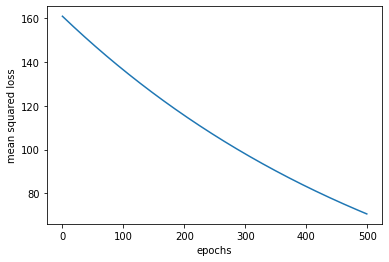

In [0]:
plot(range(num_epochs), losses)
xlabel('epochs')
ylabel('mean squared loss')

## PyTorch Optimizers

We can make our code even simpler by letting the library do the gradient updates as well! Using `torch.optim` we can choose from a variety of optimization strategies, and in this case, we can use regular `SGD`. We have to specify all the parameters we wish to optimize, so in this case it is just `weights`

/

Nous pouvons encore simplifier le code si on fais les updates de gradient automatique aussi. Avec `torch.optim`, nous pouvons choisir d'un varieté de optimisateurs, et dans cette cas, on choisit `SGD` régulier. Il faut juste préciser les paramètres qu'on veut optimiser, et le taux d'apprendisage.

Text(0, 0.5, 'mean squared loss')

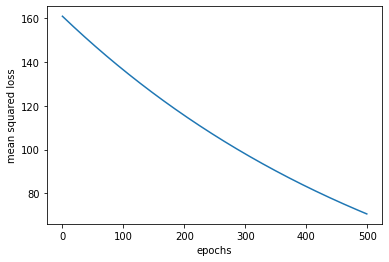

In [0]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
weights = torch.randn(num_features, num_classes, device=device, requires_grad=True)

learning_rate = 2e-5
num_epochs = 500
losses = []

# set the optimizer
optimizer = torch.optim.SGD([weights], lr=learning_rate)

for epoch in range(num_epochs):

    preds = torch.mm(x_train, weights)
    loss = (preds - y_train).pow(2).mean()
    losses.append(loss.item())

    # make sure to reset the gradients to 0 before calculation
    optimizer.zero_grad()
    loss.backward()
    # update our parameter with SGD
    optimizer.step()
    
plot(range(num_epochs), losses)
xlabel('epochs')
ylabel('mean squared loss')

## PyTorch NN

Now nearly everything is in place, except it would still be a bit of a hassle to explicitly write out all the weights, biases, and other parameters we want to optimize. This is especially true since there are a lot of very common neural network building blocks that we use all the time. The `torch.nn` part of the libary is exactly that! It gives us all the tools to write our models at a higher level, going over the small details

Here, we will replace:
- `weights` with `nn.Linear` layer
- our optimizer's listing of parameters with `model.parameters()` 
- our manual loss calculation with `nn.MSELoss`

/

Maintenant, presque tous est fait! Mais c'est encore un peu laborieux d'explicitement donner tout les poids, bias, et autres paramètres que l'on souhaite optimiser, alors que la plupart des réseaux de neurones reposent sur des même blocs de constructions. C'est à ça que sert `torch.nn`, qui nous permet de n'écrire nos modèles qu'à trés haut level en omettant les détails.

Avec notre code au dessous, on remplace:
- `weights` par la couche `nn.Linear`
- les paramètres qu'on a besoin d'optimiser par `model.parameters()` 
- notre calcul de loss à la main par `nn.MSELoss`

Text(0, 0.5, 'mean squared loss')

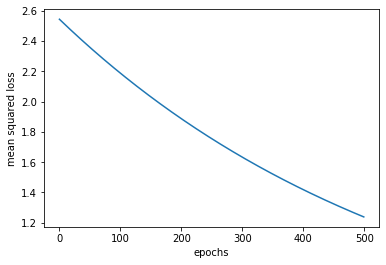

In [0]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)

# define your model
model = torch.nn.Linear(num_features, num_classes).to(device)
# choose a loss function
loss_fn = torch.nn.MSELoss()

num_epochs = 500
learning_rate = 2e-5
# automatically find all your model's parameters
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

losses = []

for epoch in range(num_epochs):
    preds = model(x_train)
    loss = loss_fn(preds, y_train)

    losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()    

    
plot(range(num_epochs), losses)
xlabel('epochs')
ylabel('mean squared loss')

There are other types of layers besides `nn.Linear`. For example, we can add a non-linear activation such as reLU with `nn.ReLU`, or add a convolution layer with `nn.Conv2d` (as we will see next week)

/

Il existe d'autres types de couche que `nn.Linear`. Par exemple, on peut ajouter une fonction d'activation non-linéaire comme reLU avec `nn.ReLU`, ou ajouter une couche avec convolution avec `nn.Conv2d` (comme nous le verrons la semaine prochaine)

## PyTorch nn.Sequential
Most of the time we want to build multi-layer neural networks. PyTorch lets us do that by using [nn.Sequential](https://pytorch.org/docs/stable/nn.html?#sequential), which wraps a sequence of layers together and turns them into one big model.

/

La plupart du temps nous voulons construire des réseaux de neurones à plusieurs couches. PyTorch nous laisse faire cela en utilisant [nn.Sequential](https://pytorch.org/docs/stable/nn.html?#sequential), qui regroupe une séquence de couches ensemble et les transforme en un gros modèle.

Text(0, 0.5, 'mean squared loss')

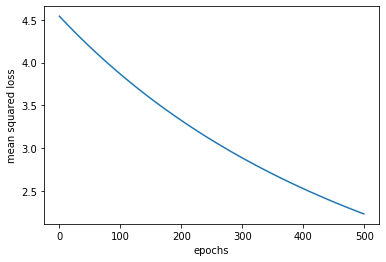

In [0]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)

model = torch.nn.Sequential(
    torch.nn.Linear(num_features, 4),
    torch.nn.Linear(4, num_classes)
).to(device)
    
loss_fn = torch.nn.MSELoss()

num_epochs = 500
learning_rate = 2e-5
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

losses = []

for epoch in range(num_epochs):
    preds = model(x_train)
    loss = loss_fn(preds, y_train)

    losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()    

    
plot(range(num_epochs), losses)
xlabel('epochs')
ylabel('mean squared loss')

## Challenge

We're now doing really well on the `iris` dataset mainly because it is so simple and neural networks are so powerful! Let's work on something a bit harder, and try our hands on the sklearn Digits dataset. This dataset contains images of handwritten digits, similarly to the famous MNIST, but with smaller dimension and size (to simplify the code in the scope of this demo)

There are 1797 images. The input images are handwritten digits (0 - 9) in a 8x8 pixel grayscale image. This means the input is a Tensor of size `1797 x 64` where each value is an "intensity" (how dark the pixel is) number between 0 and 255 (inclusive) . The output is the number that this handwritten image is showing, so between 0 and 9.

We now try using neural networks coded in PyTorch to handle this classification task. The loss function we use is softmax cross entropy (look [here](https://pytorch.org/docs/stable/nn.html?#loss-functions)).
The following code cell has an example of decently performing neural net. It is now your turn to play with the architecture and hyperparameters and see how it affects training score, test score, computation speed, etc. Try to improve the performances !

You can play with :

* number of layers
* number of neurons per layers
* device (cpu vs cuda, how does it impact speed ?)
* adding non-linear layers between linear layers (e.g. ReLU, but there are others)
* learning rate
* number of epochs
* loss function

Note that the dataset has a small number of samples and we are not using convolution layers (which are more adapted to images and which we will study next week), so the performance will have some limitations.

/

On se débrouille maintenant bien sur `iris` principalement car c'est un jeu de données simple et les réseaux de neurones sont puissants. Travaillons maintenant sur un exemple plus compliqué, le dataset `digits` de sklearn. Ce dataset contient des images de chiffres écrits à la main, comme le célèbre MNIST, mais avec moins d'exemples et de plus faible dimension (afin de simplifier le code dans le cadre de cette démo).

Il y a 1797 images. Les images sont des chiffres écrits à la main (0 - 9) dans un format 8x8 à échelle de gris. Cela veut dire que l'input est un Tensor de dimension `1797x64` où chaque valeur est une 'intensité' (à quel point le pixel est sombre) entre 0 et 255 inclut. La sortie est le chiffre que l'image montre, donc entre 0 et 9 inclut.

On essaye maintenant des réseaux de neurones implementés en PyTorch pour effectuer cette tache de classification. La fonction de coût que nous utilisons est softmax crossentropy (regardez [ici](https://pytorch.org/docs/stable/nn.html?#loss-functions)). 
Le code qui suit est un exemple de réseau de neurones avec des performances décentes. C'est maintenant votre tour de jouer avec les hyperparamètres et l'architecture et voir comment cela affecte la precision d'entrainement, la precision de test, le temps de calcul, etc. Essayez d'améliorer les performances !

Vous pouvez jouer avec :

* le nombre de couches
* le nombre de neurones par couche
* cpu vs cuda (comment cela affecte le temps de calcul ?)
* ajouter des transformations non-linéaires entre les couches linéaires, comme ReLU (mais il y en a d'autres)
* learning rate
* nombre d'époques
* fonction de perte

Remarquez que le jeu de données a un faible nombre de points et nous n'utilisons pas les couches de convolutions (plus adaptées aux images et que nous verrons la semaine prochaine), donc les performances ont des limites.

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

torch.manual_seed(0)
torch.cuda.manual_seed(0)
device = torch.device('cuda:0')

### Load Digits dataset

digits = datasets.load_digits()
(x_train, x_test, y_train, y_test) = train_test_split(digits.data, digits.target)
num_train = x_train.shape[0]
num_test = x_test.shape[0]
num_features = x_train.shape[1]
num_classes = 10
one_hot = OneHotEncoder(n_values=num_classes, sparse=False)
x_train = torch.from_numpy(x_train).float().to(device)
x_test = torch.from_numpy(x_test).float().to(device)
y_train = torch.from_numpy(y_train).long().to(device)
y_test = torch.from_numpy(y_test).long().to(device)

### Hyperparameters & architecture

model = nn.Sequential(
    nn.Linear(num_features, 200),
    nn.ReLU(),
    nn.Linear(200, 500),
    nn.ReLU(),
    nn.Linear(500, 500),
    nn.ReLU(),
    nn.Linear(500, num_classes),
).to(device)

num_epochs = 10000
learning_rate = 2e-5
loss_fn = nn.CrossEntropyLoss()

### Training

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
losses = []

for epoch in range(num_epochs):

    preds = model(x_train)
    loss = loss_fn(preds, y_train)
    losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()    

### Results
    
plot(range(num_epochs), losses)
xlabel('epochs')
ylabel('crossentropy loss')

preds_train = model(x_train)
acc = 0
for i in range(len(y_train)):
  if torch.argmax(preds_train[i]) == y_train[i]:
    acc += 1
print('train accuracy : {}'.format(acc / len(y_train)))

preds_test = model(x_test)
acc = 0
for i in range(len(y_test)):
  if torch.argmax(preds_test[i]) == y_test[i]:
    acc += 1
print('test accuracy : {}'.format(acc / len(y_test)))


NameError: ignored